In [1]:
from vector import portfolio, data_source
import importlib
import pandas as pd
import tables as tb
from datetime import datetime, timedelta, timezone
from itertools import accumulate, chain
import talib
from talib import abstract
import logging
from pymongo import MongoClient
from pymongo.database import Database
from sklearn.decomposition import PCA

In [2]:
MONGODB_HOST = "172.16.11.81"
KLINE_DB = "Kline_1Min_Auto_Db_Plus"
symbols = ['bnb', 'btc', 'eth', 'uni', 'link']
freqs = ["5min"]
utc = timezone(timedelta())

In [3]:
importlib.reload(data_source)

class DataSource(data_source.SourceManager):
    
    # 定义转换数据源命名转换规则: eth -> eth_usdt.spot:binance (MongoDB表名)
    def source_key_map(self, key: str):
        return f"{key}_usdt.spot:binance"
    
    # 定义本地缓存文件命名规则：eth -> eth
    def target_key_map(self, key: str):
        return key

ds = DataSource.from_mongodb(
    MONGODB_HOST,
    KLINE_DB,
    root = 'vector_cache' #存放缓存的默认位置
)

# 从数据库拉取一分钟数据
ds.pull(symbols, begin=datetime(2021, 1, 1, tzinfo=utc).timestamp())
# 合成不同周期k线
ds.resample(symbols, freqs)

In [4]:
result = ds.load(symbols, freqs, datetime(2021, 1, 2).timestamp(), datetime(2021, 6, 7).timestamp())
result

{'5min':                                 bnb                                            \
                                open      high       low     close      volume   
 timestamp                                                                       
 2021-01-01 16:00:00+00:00   38.1318   38.3210   38.0385   38.0522  15768.7210   
 2021-01-01 16:05:00+00:00   38.0522   38.2500   38.0495   38.2264  10953.7400   
 2021-01-01 16:10:00+00:00   38.2205   38.2528   38.1477   38.1826   7618.1260   
 2021-01-01 16:15:00+00:00   38.1856   38.2777   38.0944   38.1482   9890.6270   
 2021-01-01 16:20:00+00:00   38.1471   38.2132   38.1307   38.2132   4631.5990   
 ...                             ...       ...       ...       ...         ...   
 2021-06-06 15:35:00+00:00  391.8100  392.0800  391.2800  391.6200   4033.6036   
 2021-06-06 15:40:00+00:00  391.6100  391.6100  390.5800  390.5800   6268.6482   
 2021-06-06 15:45:00+00:00  390.5800  391.9600  390.5600  391.3800   4882.9827   
 2021-06

In [5]:
importlib.reload(data_source)
import numpy as np
#信号为矩阵计算
def cal_sig(data: pd.DataFrame,ret_param):
    ret = data['close'].pct_change(ret_param)
    return pd.DataFrame({"ret": ret})

# 数据格式转换
class Signal(data_source.DataManager):
    def handle_symbol(self, symbol: str, freq: str, data: pd.DataFrame) -> pd.DataFrame:
        if freq == "5min":
            return cal_sig(data,24)
        else:
            return super().handle_symbol(symbol, freq, data)

mas = Signal(result)
mas.prepare_data()

In [6]:
pca = PCA(n_components=5)
fiveRetData = mas.basic_data.loc[:, pd.IndexSlice[:, "ret"]].dropna()

In [7]:
absorptionRatio = {}
arPeriod = 50
for i in range(len(fiveRetData)-arPeriod):
    pca.fit(fiveRetData[i:i+arPeriod])
    absorptionRatio[fiveRetData.index[i+arPeriod]]= pca.explained_variance_ratio_[0]

In [8]:
pd.Series(absorptionRatio)[-5:]

2021-06-06 15:35:00+00:00    0.951252
2021-06-06 15:40:00+00:00    0.954911
2021-06-06 15:45:00+00:00    0.957174
2021-06-06 15:50:00+00:00    0.962577
2021-06-06 15:55:00+00:00    0.966706
dtype: float64

In [9]:
absorptionRatio = {}
arPeriod = 50
for i in range(len(fiveRetData)-arPeriod):
    pca.fit(fiveRetData[i:i+arPeriod])
    absorptionRatio[fiveRetData.index[i+arPeriod]]= pca.explained_variance_ratio_[0]

In [10]:
pd.Series(absorptionRatio)[-5:]

2021-06-06 15:35:00+00:00    0.951252
2021-06-06 15:40:00+00:00    0.954911
2021-06-06 15:45:00+00:00    0.957174
2021-06-06 15:50:00+00:00    0.962577
2021-06-06 15:55:00+00:00    0.966706
dtype: float64

In [11]:
arSeries = pd.Series(absorptionRatio)
arSeries.plot()

In [12]:
arSeries.loc[datetime(2021,5,18,):datetime(2021,5,20)]

C:\Users\channelchan\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


2021-05-18 00:00:00+00:00    0.979951
2021-05-18 00:05:00+00:00    0.978133
2021-05-18 00:10:00+00:00    0.975700
2021-05-18 00:15:00+00:00    0.974282
2021-05-18 00:20:00+00:00    0.974557
                               ...   
2021-05-19 23:40:00+00:00    0.877128
2021-05-19 23:45:00+00:00    0.871905
2021-05-19 23:50:00+00:00    0.864042
2021-05-19 23:55:00+00:00    0.864309
2021-05-20 00:00:00+00:00    0.870666
Length: 577, dtype: float64

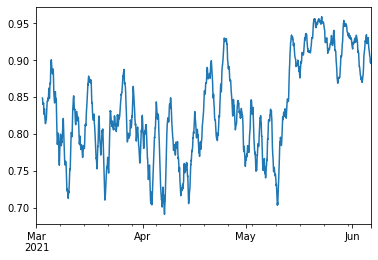

In [13]:
import talib as ta
ta.MA(arSeries.loc[datetime(2021,3,1):], 500).plot()

In [14]:
arSeries.loc[datetime(2021,4,17,):datetime(2021,4,20)]

2021-04-17 00:00:00+00:00    0.717955
2021-04-17 00:05:00+00:00    0.710737
2021-04-17 00:10:00+00:00    0.688643
2021-04-17 00:15:00+00:00    0.655477
2021-04-17 00:20:00+00:00    0.644290
                               ...   
2021-04-19 23:40:00+00:00    0.825632
2021-04-19 23:45:00+00:00    0.843080
2021-04-19 23:50:00+00:00    0.851121
2021-04-19 23:55:00+00:00    0.861269
2021-04-20 00:00:00+00:00    0.862876
Length: 865, dtype: float64

In [15]:
arSeries.loc[datetime(2021,5,11,):datetime(2021,5,20)]

2021-05-11 00:00:00+00:00    0.965413
2021-05-11 00:05:00+00:00    0.965759
2021-05-11 00:10:00+00:00    0.965550
2021-05-11 00:15:00+00:00    0.961561
2021-05-11 00:20:00+00:00    0.957022
                               ...   
2021-05-19 23:40:00+00:00    0.877128
2021-05-19 23:45:00+00:00    0.871905
2021-05-19 23:50:00+00:00    0.864042
2021-05-19 23:55:00+00:00    0.864309
2021-05-20 00:00:00+00:00    0.870666
Length: 2593, dtype: float64

In [16]:
def pca_(x):
    pca = KernelPCA().fit(x)#这里用到了apply函数。做PCA前，我们要对数据做标准化
    res = pca.lambdas_[:1].sum()/pca.lambdas_.sum()
    return res

def AR_ratio(fre,predict_fre):
    ret_mean = (bn_close.pct_change(fre).sub(bn_close.pct_change(fre).mean(axis=1),axis=0)).fillna(method='ffill')
    ret_mean = ret_mean.dropna()
    res_list = []
    for i in range(ret_mean.shape[0]-predict_fre):
        res_list.append(pca_(ret_mean.iloc[i:i+predict_fre,:]))
    res_series = pd.Series(res_list,index = ret_mean.index[predict_fre:])
    
    return res_series

In [13]:
dfTest = pd.DataFrame({"datetime":[1,2,3,4,5], 'ar':[6,6,6,6,6]}).set_index('datetime')

In [19]:
dfTest.values.flatten()

array([6, 6, 6, 6, 6], dtype=int64)